# Data Cleaning

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import scipy.stats as stats

In [4]:
df = pd.read_csv('data/kc_house_data.csv')
#df.info()

# Converting column dtypes

In [5]:
# converting date column from str to int
df['date'] = pd.to_datetime(df['date']).dt.year
#df.info()

In [6]:
#extracting zip code from address and converting to int
df['zipcode'] = df['address'].str.extract(r'\b(\d{5})[,]\s*United States\b').astype('int')

In [7]:
# lambda function to extract the first character of each object and convert it to an int.
extract_num = lambda x: int(x[:2])

# Apply the lambda function
df['grade'] = df['grade'].apply(extract_num)

In [8]:
condish = {'Poor': 1,'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
df.condition = [condish[item] for item in df.condition]

In [9]:
df['nuisance'] = df['nuisance'].map({'YES': 0, 'NO': 1})
df['greenbelt'] = df['greenbelt'].map({'YES': 1, 'NO': 0})
df['waterfront'] = df['waterfront'].map({'YES': 1, 'NO': 0})

In [10]:
# can add these features in to the equation when doing OLS 
# creating new columns for renovation features bed vs bath
#df['bath_bed'] = df['bathrooms']/df['bedrooms']
#df['bed_bath'] = df['bedrooms']/df['bathrooms']
#df['bed_bath_sum'] = df['bedrooms']+df['bathrooms']

# Filtering out rows not in King County

In [11]:
#filtering out adresses not in Washington
df_wash = df[df['address'].str.contains('Washington')]
#df_wash.info()

#### URL for King County Coordinate info
[King County Coordinates and Zipcode info](https://www5.kingcounty.gov/sdc/FGDCDocs/ZIPCODE_fgdc.htm)

In [12]:
df_king = df_wash[(df_wash['lat'] >= 46.71) 
                       & (df['lat'] <= 48.31) 
                       & (df['long'] >= -123.07) 
                       & (df['long'] <= -119.90)]
#df_king.info()

#### (Keeping the following code for view, heat_source, and sewer_system until we get a better idea of what we want to do with them but for now it seems like they have little correlation with price)

In [13]:
#NOT SURE WHAT TO DO WITH VIEW. TAKES AWAY 90% OF DATA WHEN TAKING AWAY 'NONE'

#views = {'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}
#df_copy2 = df_copy2.replace(to_replace='NONE', value=np.nan).dropna()
#df_king.view = [views[item] for item in df_king.view]

In [14]:
#one-hot encoding heat source
#heat = {'heat_source': ['Gas', 'Electricity', 'Oil', 'Gas/Solar',
#                        'Electricity/Solar', 'Other', 'Oil/Solar']}

# One-Hot Encoding 'heat_source' column
#df_encoded_heat = pd.get_dummies(df, columns=['heat_source'])

#df_encoded_heat.info()

In [15]:
#one-hot encoding sewer_system
#sewer = {'sewer_system': ['PUBLIC', 'PRIVATE', 'PRIVATE RESTRICTED', 'PUBLIC RESTRICTED']}

# One-Hot Encoding 'heat_source' column
#df_encoded_sew = pd.get_dummies(df, columns=['sewer'])

#df_encoded_heat.info()

# Dropping Null, Duplicate, and Unecessary Columns

In [16]:
df_king.drop(['id', 'address'], axis=1, inplace=True)
#df_king.info()

In [17]:
# note, may want to revisit these values as features 

# dropping lat, long and view, sqft_lot, sewer_system, heat_source, date for 
#easier view in heatmap since there is little correlation with price
#df_king.drop(['lat', 'long', 'view', 'heat_source', 'sewer_system', 'sqft_lot', 'date', 'yr_renovated'], axis=1, inplace=True)

In [18]:
df_king.drop_duplicates(inplace=True)
#df_king.info()

In [19]:
df_king.dropna(inplace=True)
df_king.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29185 entries, 0 to 30154
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           29185 non-null  int64  
 1   price          29185 non-null  float64
 2   bedrooms       29185 non-null  int64  
 3   bathrooms      29185 non-null  float64
 4   sqft_living    29185 non-null  int64  
 5   sqft_lot       29185 non-null  int64  
 6   floors         29185 non-null  float64
 7   waterfront     29185 non-null  int64  
 8   greenbelt      29185 non-null  int64  
 9   nuisance       29185 non-null  int64  
 10  view           29185 non-null  object 
 11  condition      29185 non-null  int64  
 12  grade          29185 non-null  int64  
 13  heat_source    29185 non-null  object 
 14  sewer_system   29185 non-null  object 
 15  sqft_above     29185 non-null  int64  
 16  sqft_basement  29185 non-null  int64  
 17  sqft_garage    29185 non-null  int64  
 18  sqft_p

# 3. Looking at heatmap of new dataset 

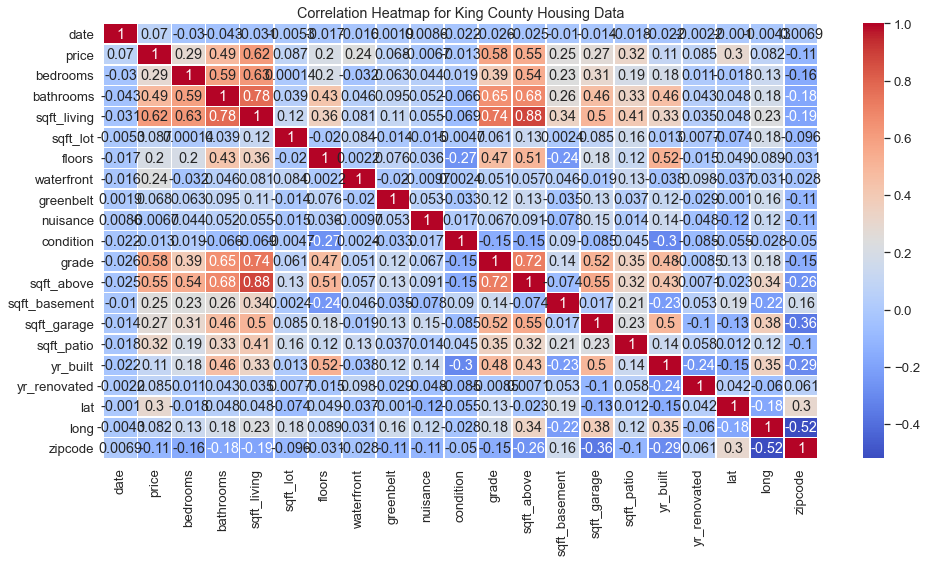

In [20]:
corr_matrix = df_king.corr(method='pearson')

sns.set(font_scale=1.2)
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for King County Housing Data")
plt.show()

In [21]:
df_king.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.616653
grade            0.578150
sqft_above       0.546015
bathrooms        0.488002
sqft_patio       0.317650
lat              0.297512
bedrooms         0.290890
sqft_garage      0.267314
sqft_basement    0.246409
waterfront       0.239685
floors           0.200073
yr_built         0.106232
sqft_lot         0.086743
yr_renovated     0.085475
long             0.081641
date             0.069781
greenbelt        0.068320
nuisance        -0.006685
condition       -0.012914
zipcode         -0.105096
Name: price, dtype: float64

In [22]:
# Testing all variables together, this model provides the highest R squared. So far.

y = df_king['price']
X = df_king.drop(['price','view', 'heat_source', 'sewer_system','nuisance','greenbelt'], axis=1)
#dropped elements that returned high P values.

model = sm.OLS(y, sm.add_constant(X)).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     2051.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        08:43:39   Log-Likelihood:            -4.2946e+05
No. Observations:               29185   AIC:                         8.590e+05
Df Residuals:                   29166   BIC:                         8.591e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.752e+08   1.64e+07    -16.788

# Assumption Testing & Model Improvement:

## 1. # Linearity Residual plots

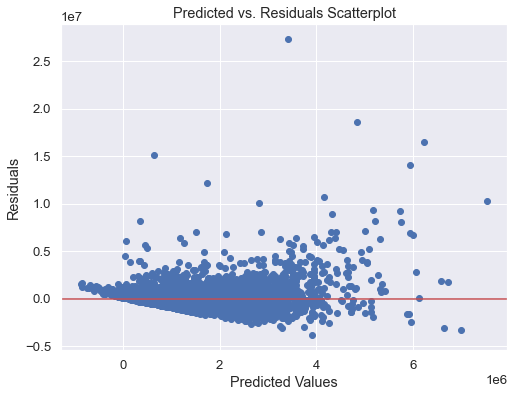

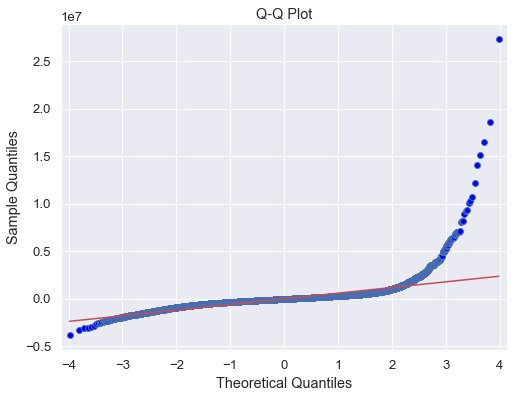

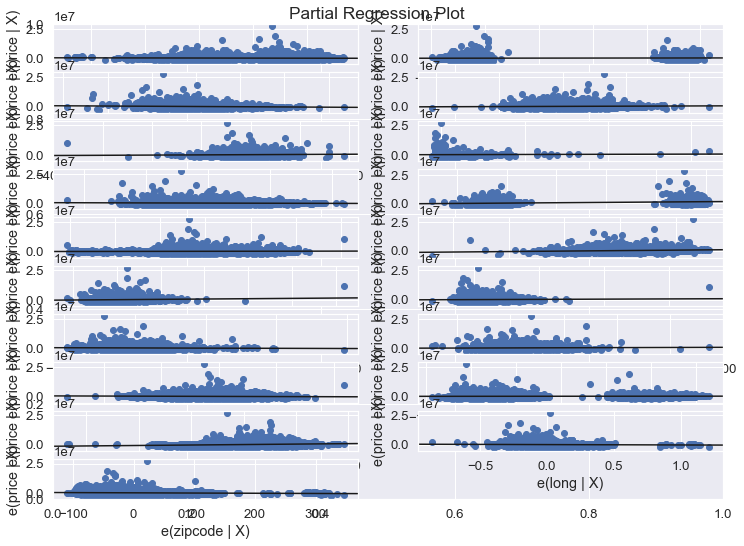

In [23]:
# Residual plots
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(model.predict(), model.resid)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Predicted vs. Residuals Scatterplot')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

# Partial regression plots
fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

## 2. **Normality Assumption**: Assumes that residuals or errors are normally distributed.

- The **Omnibus test** is used to detect normality assumption. A low probability value suggests that the distribution of errors or residuals is not normal. In this case, the p-value for the Omnibus test is 0.000 which means that we can reject the null hypothesis of normal distribution of residuals and conclude that the normality assumption is violated.
- **Jarque-Bera** (JB) test is also used to check for normality assumption. The JB test statistic measures whether the data has skewness or kurtosis values matching a normal distribution. If the test statistic is large and/or the p-value is low, then skewness and/or kurtosis are not similar to a normal distribution. With a very large test statistic of 50073454.459 and the p-value of 0.00, we can reject the null hypothesis of normality, indicating a violation of normality assumption.
- **Skewness** measures the degree of asymmetry of a probability distribution. A symmetrical distribution will have a skewness of 0. Positive skewness means there are more observations on the left side of the distribution, while negative means more observations on the right side. Here, the skewness value of 8.237 indicates positive skewness.
- **Kurtosis** measures the degree of peakness of a probability distribution. A normal distribution has a kurtosis of 3, and if it is greater than 3, it is said to be leptokurtic or heavy-tailed, and if it is less than 3, it is said to be platykurtic or light-tailed. The value of Kurtosis here is exceptionally high at 205.252 reflecting a severe deviation from normality.

## 3.Homoscedasticity Assumption: Assumes that the variance of residuals is constant across observations or independent variable values.
- need to look into this

## 4. **Independence Assumption**: Assumes that residuals are notcorrelated with each other.
- The **Durbin-Watson** test is used to detect autocorrelation in the residuals or errors. The test statistic ranges from 0 to 4 with a value of 2 indicating no autocorrelation. A value close to 2 indicates no autocorrelation as well. Here, the test statistic is 1.938, which suggests mild positive autocorrelation in residuals.

In [24]:
df_kurt = df_king.drop(['view', 'heat_source', 'sewer_system','nuisance','greenbelt'], axis=1)
df_kurt.kurtosis()

#higher kurtosis.

## in a function  get median kurtosis, if any of the kurtosis is greater than the median standard deviation then return
## something like....   if any x in kurtosis is > 1 std of the median of kurtosis. then set kurtosis 
## or something like.  if any Kurtosis is greater 20 our assumption is violated.

date              -1.666520
price            108.591489
bedrooms           1.979045
bathrooms          2.369482
sqft_living        6.734047
sqft_lot         769.714754
floors            -0.280645
waterfront        52.477698
condition          0.009730
grade              1.350150
sqft_above         4.806655
sqft_basement      2.066927
sqft_garage        2.173399
sqft_patio        11.740751
yr_built          -0.735349
yr_renovated      16.393160
lat               -0.850855
long               1.334823
zipcode           -0.139144
dtype: float64

In [25]:
X.keys()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'sqft_garage', 'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'zipcode'],
      dtype='object')

In [26]:
df_kurt=pd.concat([X, y], ignore_index=True, axis=1, join='outer')

kurt=df_kurt.kurtosis()


kurt.values

median=np.median(kurt.values)
std=(stats.median_abs_deviation(kurt.values))
upper=median+(3*std)
lower=median-(3*std)

for j in kurt.values:
    if j > upper:
        print('Failed')
    elif j < lower:
        print('Failed')
        

Failed
Failed
Failed
Failed
Failed


In [27]:
#Rough Sudeo Code.  Function Tests Each Result, If a model fails it saves the results into a dictionary.
#Based on the results of the dictionary the function then manipulates the model again looking for 
#Make a function to test the model.  

##return best features.  For each coeffeicnt x_1 x_2 if Coefficent is > than .4 | < -.4 append a list?

from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import omni_normtest
from scipy import stats



def modtest(model):
        results={}
        #Checking Linearity  should it do this for each coefficent? can this be used on each one? Would need to run a model for each factor compared to price and then return a seperate model fo each and then test it for linearity
        rainbow=linear_rainbow(model)
        if rainbow[1]>.05:
            results['Linerarity']=True
        else:
            results['Linerarity']=False
            
        #indepednence
            #Omnibus seems used in comparing two models to each other? a very different function if so
        omni=omni_normtest(model.resid)[1]
        omni=float(omni)
        if omni > .05:
            results['Omni']=True
        elif omni < .05:    
            results['Omni']=False
            
         #Durb Watson
        if durbin_watson(model.resid)> 1.5:
            results['Independence']=True
        elif durbin_watson(model.resid)< 2.5:    
            results['Independence']=True
        elif durbin_watson(model.resid)<1.5:
            results['Independence']=False
        elif durbin_watson(model.resid)> 2.5:
            results['Independence']=False


            
        # Homoskedasticity Test:
        skedastic=het_breuschpagan(model.resid, sm.add_constant(X))
        if skedastic[3]>.05:
            results['Homoskedasticity']=True
        elif skedastic[3]<.05:
            results['Homoskedasticity']=False

        #multilcolinarirty?
        if model.condition_number > 1000:
            results['Multicollinearity Test']=False
        else:
            results['Multicollinearity Test']=True
        
        return results



In [28]:
modtest(model)

{'Linerarity': False,
 'Omni': False,
 'Independence': True,
 'Homoskedasticity': False,
 'Multicollinearity Test': False}

## 5. Outlier Detection with box plots

### (only real outliers contained in price. Rest of the entries have outliers but price holds the most and after removing all outliers we are left with a dataframe of nearly 26k entries. 

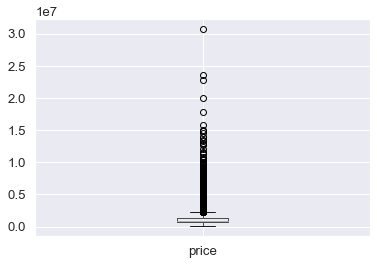

In [29]:
df_king.boxplot(column=['price'])

plt.show()

In [30]:
#df_king_price =df_king[df_king['price'] <= 1000000]
#df_king_price.info()

In [31]:
#df_king1 = df_king[df_king['sqft_living'] <= 9000]
#df_king1.info()

In [32]:
#df_king2 = df_king1[df_king1['sqft_above'] <= 9000]
#df_king2.info()

In [33]:
#df_king3 = df_king2[df_king2['sqft_patio'] <= 2000]
#df_king3.info()

In [34]:
#df_king4 = df_king3[df_king3['sqft_garage'] <= 2000]
#df_king4.info()

In [35]:
#df_king5 = df_king4[df_king4['sqft_basement'] <= 2000]
#df_king5.info()

In [36]:
#df_king_county = df_king5[df_king5['price'] <= 1882000]
#df_king_county.info()

In [37]:
#df_king_county.boxplot(column=['price'])

#plt.show()

## 6. **Multicollinearity Detection**: If there are multiple independent variables, detect and remove multicollinearity as it could inflate standard errors,resulting in unreliable estimates
- **The Condition number (Cond. No.)** measures multicollinearity among the independent variables. A higher value indicates that the independent variables are highly correlated, which can lead to unreliable coefficients. Here, the Condition Number is 5.66e+03, which suggests a high degree of multicollinearity.

# Column Names and Descriptions for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model.


### Condition Column info:

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

### Grade Column Info:

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

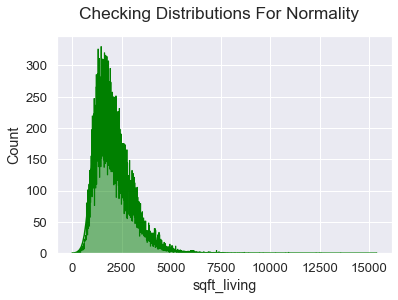

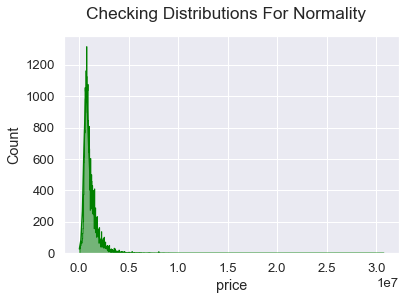

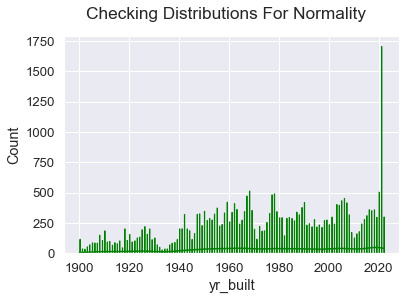

In [38]:
#Normally Distributed

def normalitycheck(column):
    
    fig, ax = plt.subplots()
    n=len(column)
    sns.histplot(column, bins=int((n/30)), element="step", kde=True, color="green", ax=ax)
    fig.suptitle("Checking Distributions For Normality");
    return 

#for j in df_king.keys():


variables=['sqft_living','price','yr_built']

for j in variables:
    normalitycheck(df[j])
    
    


<AxesSubplot:xlabel='zipcode', ylabel='price'>

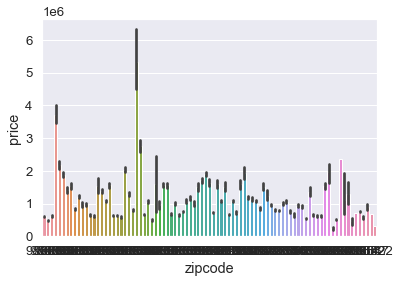

In [39]:
zipcodegroups=df_king.groupby(['zipcode'])


x=df_king['zipcode']
y=df_king['price']

sns.barplot(x=x , y=y, data=df_king)

#something to consider... there is definetely more than 30,000 homes in King county

#for x in topzips:
#    filler=df_king[df_king['zipcode']==x]
#    y=filler['price']
#    x=filler['sqft_living']
    
    

In [40]:
df_king['yr_renovated'].value_counts()

#drop everything that isn't Zero
#drop everything that is zero.  Compare the two

0       27817
2021       69
2006       49
2018       44
1990       42
        ...  
1924        1
1972        1
1948        1
1942        1
1966        1
Name: yr_renovated, Length: 82, dtype: int64

In [41]:
neverrennovated=df_king[df_king['yr_renovated']==0]
rennovated=df_king[df_king['yr_renovated']!=0]

In [42]:


stats.ttest_ind(a=neverrennovated['price'],b=rennovated['price'], equal_var=False)


Ttest_indResult(statistic=-9.467085439171141, pvalue=1.1545987218477567e-20)

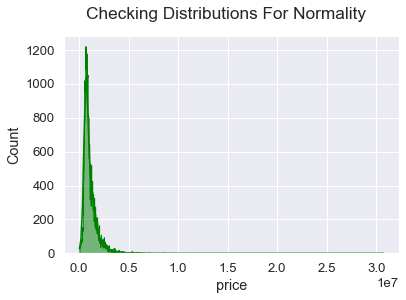

In [43]:
    column=neverrennovated['price']
    fig, ax = plt.subplots()
    n=len(column)
    sns.histplot(column, bins=int((n/30)), element="step", kde=True, color="green", ax=ax)
    fig.suptitle("Checking Distributions For Normality");

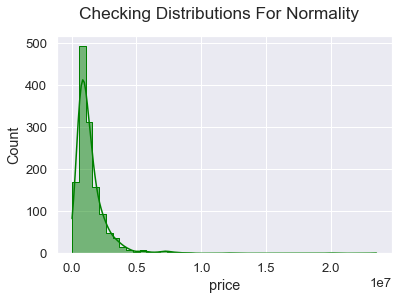

In [44]:
    column=rennovated['price']
    fig, ax = plt.subplots()
    n=len(column)
    sns.histplot(column, bins=int((n/30)), element="step", kde=True, color="green", ax=ax)
    fig.suptitle("Checking Distributions For Normality");

In [45]:
def centraltend(column):
    print("Mode: ", column.mode())
    print("Median: ", column.median())
    print("Mean: ", column.mean())
    return

In [46]:
centraltend(neverrennovated['price'])

Mode:  0    650000.0
dtype: float64
Median:  860000.0
Mean:  1096258.862458209


In [47]:
centraltend(rennovated['price'])

Mode:  0    950000.0
dtype: float64
Median:  1100000.0
Mean:  1457273.8567251463


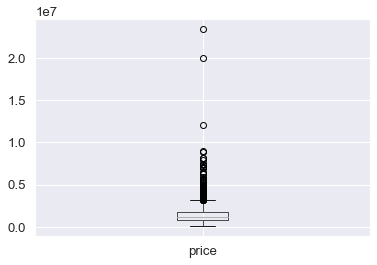

In [48]:
rennovated.boxplot(column=['price'])

plt.show()

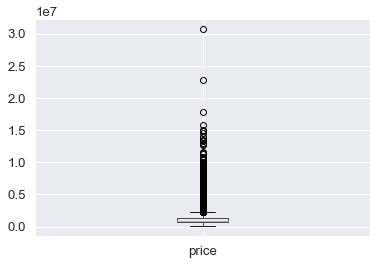

In [49]:
neverrennovated.boxplot(column=['price'])

plt.show()

In [50]:
cleanneverreno=neverrennovated[neverrennovated['price']<1500000]
cleanreno=rennovated[rennovated['price']<1500000]

<AxesSubplot:>

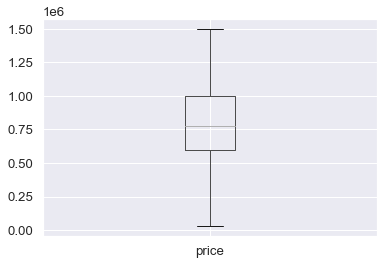

In [51]:
cleanneverreno.boxplot(column=['price'])

<AxesSubplot:>

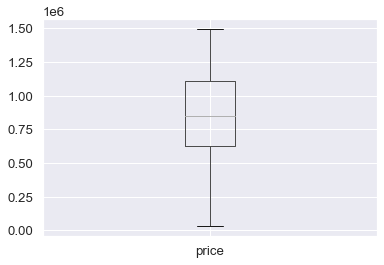

In [52]:
cleanreno.boxplot(column=['price'])

In [53]:
stats.ttest_ind(a=cleanreno['price'],b=cleanneverreno['price'], equal_var=False)

Ttest_indResult(statistic=5.214062352238707, pvalue=2.2478924168610176e-07)

In [54]:
centraltend(df_king['price'])

Mode:  0    650000.0
dtype: float64
Median:  869000.0
Mean:  1113180.860476272


In [55]:
df_king['price'].value_counts().head(60)

650000.0     339
750000.0     295
800000.0     289
600000.0     289
850000.0     285
700000.0     276
1100000.0    275
1200000.0    273
950000.0     245
550000.0     243
500000.0     243
900000.0     233
1000000.0    228
1050000.0    216
675000.0     207
1500000.0    204
1300000.0    195
1250000.0    191
1400000.0    185
1150000.0    181
875000.0     179
725000.0     176
825000.0     168
575000.0     167
450000.0     167
775000.0     166
1600000.0    162
1350000.0    146
525000.0     132
925000.0     129
560000.0     129
625000.0     124
1800000.0    124
680000.0     124
475000.0     119
660000.0     116
760000.0     115
1700000.0    115
620000.0     114
975000.0     114
610000.0     113
860000.0     113
2000000.0    111
730000.0     110
630000.0     109
1450000.0    107
710000.0     107
1650000.0    106
640000.0     104
820000.0     104
740000.0     101
1550000.0    101
580000.0     101
810000.0      96
540000.0      95
400000.0      94
615000.0      93
520000.0      92
685000.0      

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

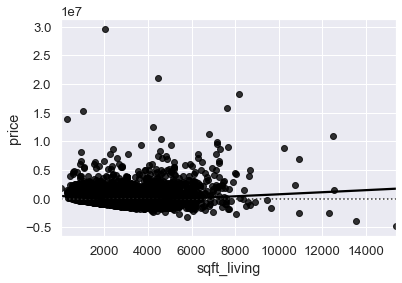

In [56]:
sns.residplot(x = "sqft_living",
              y = "price",
              data = df_king,
             lowess=True,color='Black')

In [57]:
#could be a function. but isnt that what a pair plot is.. oh yeah,.


data = df_king
y_mpg = data["price"]
x_mpg = data["acceleration"]


model = sm.OLS(y_mpg, sm.add_constant(x_mpg))
results = model.fit()
slope = results.params["acceleration"]
intercept = results.params["const"]
fit_line_mpg = slope * x_mpg + intercept

ax.scatter(x_mpg, y_mpg, color="mediumaquamarine", alpha=0.5, label="data points")
ax.plot(x_mpg, fit_line_mpg, color="gray", label="best-fit line")
ax.plot(x_mpg, top_line, color="orange")
ax.plot(x_mpg.sort_values(), bottom_line, color="orange")

KeyError: 'acceleration'

In [66]:
## writing a homeskedasitcy function:
from statsmodels.stats.diagnostic import het_breuschpagan





skeda=X.keys()

for x in skeda:
    skedamodel = sm.OLS(y, sm.add_constant(df_king[x])).fit()
    skedastic=het_breuschpagan(skedamodel.resid, sm.add_constant(X))
    print("Homoskedasticty: ",skedastic[3])
    if skedastic[3]>.05:
        print(True)
    elif skedastic[3]<.05:
        print(True)

        
## could just call it a line function.

#why dont i try a function out of the skedamodel and test.
        
        
        
    
##couple options.  Try except.  Try doing the dictionary thing again or just but a bunch of nested ifs... could be alittle un pythonic 
##tooo many ideas.... just pick one... and use another if its neccessary. no need to try and show off.
            
            
## so none of them are pass the test. Lets try square rooting, logging a,d reciporcal square rooting.



    # Logging
    # should try making a graph for each method... for comparision in the event that none returned the result we wanted.
    


Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  2.3693283352097597e-283
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True
Homoskedasticty:  0.0
True


In [105]:
#check how many are rennovated versus not
#check how many are recently built

## maybe compare year built to if rennovated... 
## okay im struglging in framing this... why isnt it clicking.. might need a walk.... walk done :)
## so.. I want to transfomr yr_rennovated by... oh, by how recently its been renovated.  


#looking at houses built 

df_king[df_king['yr_renovated']>0]['yr_built'].value_counts()
#houses rennovated by year built.

len(df_king[df_king['yr_renovated']>0])


## need a graph for these.
#what kind of graphs:
#Bar Graph comparing the means of each.
#Bar Graph showing the number of rennovated to unrennovated homes
#Bar Graph showing zip codes.. nah just these two...

df_king[df_king['yr_renovated']>0]['price'].mean()

#sns.barplot(x=, y=)



1457273.8567251463

In [128]:
#need a reno column

df_king['reno']="String"

for j in df_king['yr_renovated']:
    if j>0:
        j['reno']=True
    else:
        j['reno']=False

        


TypeError: 'int' object does not support item assignment

In [129]:
#this works!!!

df_king['not_renovated'] = (df_king['yr_renovated'] == 0).astype(int)
df_king

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode,reno,not_renovated
0,2022,675000.0,4,1.0,1180,7140,1.0,0,0,1,...,0,0,40,1969,0,47.461975,-122.19052,98055,String,1
1,2021,920000.0,5,2.5,2770,6703,1.0,0,0,0,...,1570,0,240,1950,0,47.711525,-122.35591,98133,String,1
2,2021,311000.0,6,2.0,2880,6156,1.0,0,0,1,...,1580,0,0,1956,0,47.502045,-122.22520,98178,String,1
3,2021,775000.0,3,3.0,2160,1400,2.0,0,0,1,...,1070,200,270,2010,0,47.566110,-122.29020,98118,String,1
4,2021,592500.0,2,2.0,1120,758,2.0,0,0,0,...,550,550,30,2012,0,47.532470,-122.07188,98027,String,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,2021,1555000.0,5,2.0,1910,4000,1.5,0,0,1,...,1130,0,210,1921,0,47.664740,-122.32940,98103,String,1
30151,2021,1313000.0,3,2.0,2020,5800,2.0,0,0,1,...,0,0,520,2011,0,47.565610,-122.38851,98116,String,1
30152,2022,800000.0,3,2.0,1620,3600,1.0,0,0,0,...,920,240,110,1995,0,47.610395,-122.29585,98122,String,1
30153,2022,775000.0,3,2.5,2570,2889,2.0,0,0,1,...,740,480,100,2006,0,47.449490,-122.18908,98055,String,1


In [ ]:
df_king

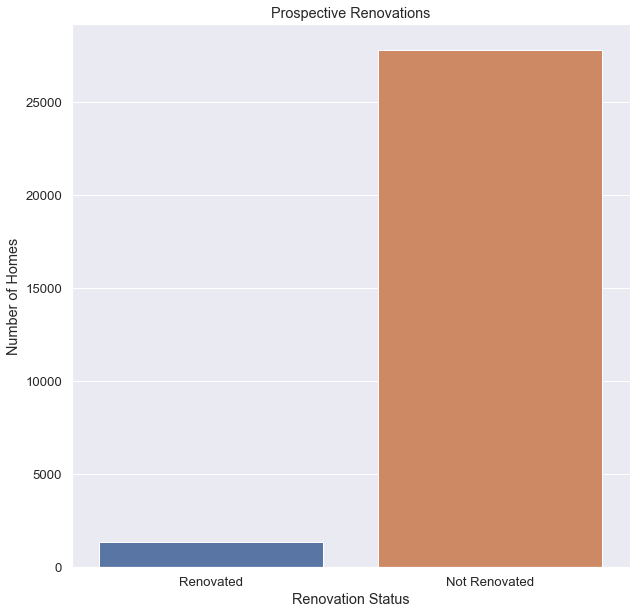

In [175]:
result = df_king.groupby(['not_renovated']).size()
 
# plot the result
fig, ax = plt.subplots(figsize=(10,10))

g=sns.barplot(x = result.index, y = result.values)
g.set_xticklabels(['Renovated', 'Not Renovated'])
g.set_xlabel('Renovation Status')
g.set_ylabel('Number of Homes')
g.set_title('Prospective Renovations')

plt.savefig('Renovationcompare.png')

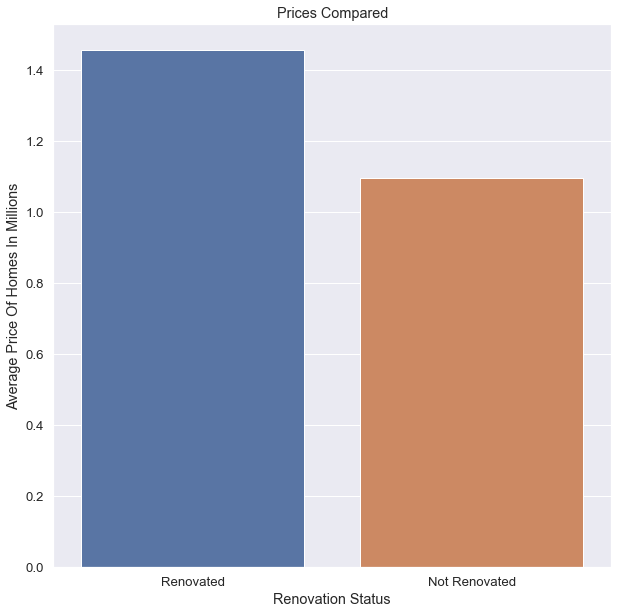

In [177]:
result = df_king.groupby(['not_renovated'])['price'].mean()

result# plot the result
fig, ax = plt.subplots(figsize=(10,10))

g=sns.barplot(x = result.index, y = result.values/1000000)
g.set_xticklabels(['Renovated', 'Not Renovated'])
g.set_xlabel('Renovation Status')
g.set_ylabel('Average Price Of Homes In Millions')
g.set_title('Prices Compared')

plt.savefig('Renovationprice.png')

In [135]:
df_king['reno']
df_king

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode,reno,not_renovated
0,2022,675000.0,4,1.0,1180,7140,1.0,0,0,1,...,0,0,40,1969,0,47.461975,-122.19052,98055,String,1
1,2021,920000.0,5,2.5,2770,6703,1.0,0,0,0,...,1570,0,240,1950,0,47.711525,-122.35591,98133,String,1
2,2021,311000.0,6,2.0,2880,6156,1.0,0,0,1,...,1580,0,0,1956,0,47.502045,-122.22520,98178,String,1
3,2021,775000.0,3,3.0,2160,1400,2.0,0,0,1,...,1070,200,270,2010,0,47.566110,-122.29020,98118,String,1
4,2021,592500.0,2,2.0,1120,758,2.0,0,0,0,...,550,550,30,2012,0,47.532470,-122.07188,98027,String,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,2021,1555000.0,5,2.0,1910,4000,1.5,0,0,1,...,1130,0,210,1921,0,47.664740,-122.32940,98103,String,1
30151,2021,1313000.0,3,2.0,2020,5800,2.0,0,0,1,...,0,0,520,2011,0,47.565610,-122.38851,98116,String,1
30152,2022,800000.0,3,2.0,1620,3600,1.0,0,0,0,...,920,240,110,1995,0,47.610395,-122.29585,98122,String,1
30153,2022,775000.0,3,2.5,2570,2889,2.0,0,0,1,...,740,480,100,2006,0,47.449490,-122.18908,98055,String,1


In [184]:
import requests
import urllib
urllib.

#Sample latitude and longitudes
lat = 40
lon = -75

#Encode parameters 
params = urllib.urlencode({'latitude': lat, 'longitude':lon, 'format':'json'})
#Contruct request URL
#url = 'https://geo.fcc.gov/api/census/block/find?' + params

#Get response from API
#response = requests.get(url)

#Parse json in response
#data = response.json()

#Print FIPS code
#print data['County']['FIPS']

AttributeError: module 'urllib' has no attribute 'urlencode'